In [117]:
# !wget -O miyajima_sample.csv "https://github.com/tksakaki/kspub_ds_text_analytics/tree/main/Chapter06/text/miyajima_sample.csv"

In [118]:
from collections import Counter
import sys
sys.path.append("/Users/ruinz/.pyenv/versions/3.9.5/lib/python3.9/site-packages")
import spacy
import pandas as pd

# 使用する単語の品詞とストップワードの指定
include_pos = ('NOUN', 'PROPN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう',
             'なる', 'ほう', 'いる', 'くる', 'お', 'できる')

# 口コミデータの読み込み
df = pd.read_csv('./miyajima_sample.csv', encoding='utf-8',
                 parse_dates=['旅行の時期'])

# 口コミに含まれている空行を削除
df['口コミ'] = df['口コミ'].replace('\n+', '\n', regex=True)

nlp = spacy.load('ja_ginza')

# 出現する単語をリストに追加
words = []
for doc in nlp.pipe(df['口コミ'] ):
    words.extend([token.lemma_ for token in doc
                  if token.pos_ in include_pos and
                  token.lemma_ not in stopwords])

# 単語の頻度をカウント
counter = Counter(words)

print('count word')
for word, count in counter.most_common(10):
    print(f'{count:>5} {word}')

count word
  209 宮島
  133 行く
   96 食べる
   84 もみじ
   77 思う
   74 厳島神社
   66 牡蠣
   52 水族館
   52 鹿
   48 お店


In [119]:
# 口コミの件数を算出　
count = len(df)
print('口コミの件数', count)

# 口コミの平均文字数を算出
word_count = 0
for review in df['口コミ']:
    word_count += len(review)

ave = word_count / count
print('口コミの平均文字数', round(ave, 1))

口コミの件数 176
口コミの平均文字数 174.9


In [120]:
df

,居住地,年代,性別,旅行の時期,同行者,評価,タイトル,口コミ
0,広島,50代,男性,2021-10-01,家族,とても良い,まあきてみんさい,自然の景色 雅な社殿 ときめきいっぱいの商店街 海のにおい いいよお
1,広島,30代,女性,2021-10-01,友達,とても良い,魅力満載のワンダーアイランドです！,パワースポットでもある厳島神社を参拝したり、牡蠣やもみじ饅頭、穴子飯をはじめとしたグルメは有...
2,広島,30代,女性,2021-10-01,家族,とても良い,宮島グルメ,宮島のグルメを楽しむために母と訪問しました。昼食は、牡蠣屋という牡蠣料理専門店で牡蠣屋定食を...
3,広島,10代,男性,2021-10-01,カップル・夫婦,とても良い,牡蠣の聖地,牡蠣好きには堪らないです！！
4,広島,20代,女性,2021-10-01,友達,とても良い,宮島観光,試験の帰りに宮島へ寄りました。フェリーから降りてすぐに昼食をとろうとなり、商店街を歩きました...
...,...,...,...,...,...,...,...,...
171,愛媛,50代,男性,2008-08-01,ビジネス,とても良い,街並み,観光気分を味わえる。街並みが綺麗である。
172,広島,50代,男性,2007-09-01,家族,とても良い,宮島へ,広島で働くことが決まったので、家族で広島を見学に来ました。せっかくなので、観光地の宮島へ行き...
173,広島,10代,男性,2003-12-01,家族,普通,可もなく不可もなく,幼い頃に行くのは楽しいが大学生、社会人になるにつれ行く意欲が湧かない
174,広島,10代,男性,2001-12-01,カップル・夫婦,とても良い,宮島はとてもいい場所！！！！,シカが可愛かった❤


## 口コミの共起ネットワーク

In [121]:
# analyze_cooccurrency_miyajima.py


# 使用する単語の品詞とストップワードの指定
include_pos = ('NOUN', 'PROPN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう',
             'なる', 'ほう', 'いる', 'くる', 'お', 'つ', 'おる', 'とき', 'しまう',
             'いく', 'みる', 'ため', 'ところ', '際', '他', '時', '中', '方', '目', 
             '回', '年', '点', '前', '後', '思う', '行く')



In [122]:
def extract_words(sent, pos_tags, stopwords):
    words = [token.lemma_ for token in sent
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_cooccurrence(sents, token_length='{2,}'):
    token_pattern=f'\\b\\w{token_length}\\b'
    count_model = CountVectorizer(token_pattern=token_pattern)

    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)

    X[X > 0] = 1
    Xc = (X.T * X) 
    return words, word_counts, Xc, X

In [124]:
def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc, weight_cutoff):
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [(words[i], words[j], Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

In [125]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import japanize_matplotlib

def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

In [126]:
# 口コミを解析し共起を算出 
sents = []
for doc in nlp.pipe(df['口コミ']):
    sents.extend([' '.join(extract_words(sent, include_pos, stopwords))
                  for sent in doc.sents])

words, word_counts, Xc, X = count_cooccurrence(sents, token_length='{1,}')

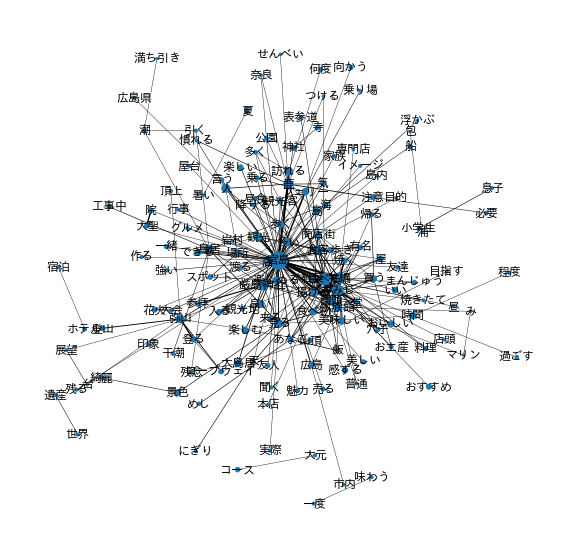

In [127]:
#　ネットワークの生成
sents = []
G = create_network(words, word_counts, Xc, 0.015)

#静的ネットワークの描画
pyplot_network(G)

#動的ネットワークの描画
pyvis_G = nx2pyvis_G(G)
pyvis_G.show('mygraph_miyajima.html')


In [128]:
import re

# 「鳥居」と「残念」という単語が含まれている口コミを表示
print('year', 'review')
for doc in nlp.pipe(df['口コミ']):
    for sent in doc.sents:
        sent = sent.text
        if re.search('鳥居', sent) and re.search('残念', sent):
            date = df[df['口コミ'] == doc.text]['旅行の時期']
            date = date.iloc[-1]
            sent = re.sub('\n', '', sent)
            print(date.year, sent)

year review
2021 鳥居を見ましたが、改修工事をしていたため全貌を見れず残念でした。
2020 厳島神社の大鳥居が改装中で幕に覆われていたのは残念でしたが、その分、秋の行楽シーズンにしては空いていて本社拝殿をじっくり歩くことができました。
2020 大鳥居が見えないのは残念ですが、夜は、保存修理中の大鳥居がライトアップされて金色に輝き、これはこれで貴重な景色だと思います。
2019 ただ、観光のメインである大鳥居が修繕中だったのが残念でした。
2019 鳥居が工事中で、記念撮影をしたかったですが、残念でした。
2019 当時、厳島神社の大鳥居が工事中で残念でしたが、宮島花火大会名物の水上花火は圧巻の美しさでした。
2019 友人は楽しんでいましたが、やはり目玉の鳥居を見ることができなかったのは残念です。
2019 鳥居をメインに見に来ましたが干潮の時刻を過ぎていたため鳥居の真下までは行けなかったのと曇りだったのが少し残念でした。


In [129]:
# for doc in nlp.pipe(df['口コミ']):
#     print("0000000000000000000000000000000000000")
#     for sent in doc.sents:  
#       print(sent)
#       print("=====================")
        

## 宮島の食に関する分析

In [130]:
# NER
import spacy 
from spacy import displacy
nlp = spacy.load('ja_ginza')

text = "宇都宮にきたのに餃子も食べないの？"
doc = nlp(text)

#固有表現を抽出
for ent in doc.ents:
  print(ent.text, ent.label_)

#固有表現の抽出結果を可視化
displacy.render(doc, style="ent")

宇都宮 Province
餃子 Dish


In [131]:
import pandas as pd
from IPython.display import clear_output

# 口コミデータの読み込み
df = pd.read_csv('miyajima_sample.csv', encoding='utf-8', parse_dates=['旅行の時期'])

# 固有表現抽出の結果を表示
for doc in nlp.pipe(df['口コミ']):
    # 固有表現を抽出
    for ent in doc.ents:
        print(ent.text, ent.label_)
    # 固有表現の抽出結果を可視化
    if doc.ents:
        displacy.render(doc, style='ent')
    print('='*80)

clear_output()

## NERモデルにいくつかの語を足す

In [132]:
# do_ner3.py

from spacy.pipeline import EntityRuler

# 2. 固有表現抽出のルールを追加
patterns = [
    {'label': 'Dish', 'pattern': [
        {'TEXT': 'あなご'},
        {'TEXT': {'REGEX': r'飯|めし'}},
    ]},
    {'label': 'Dish', 'pattern': '揚げもみじ'},
    {'label': 'Dish', 'pattern': 'ガンス'},
    {'label': 'Dish', 'pattern': [
        {'TEXT': 'にぎり'},
        {'TEXT': '天'}
    ]},
    {'label': 'Dish', 'pattern': [
        {'TEXT': 'もみじ'},
        {'TEXT': '饅頭'}
    ]}
]

# ruler = EntityRuler(nlp, overwrite_ents=True)
ruler = nlp.add_pipe("entity_ruler", before='ner')
ruler.add_patterns(patterns)
# nlp.add_pipe(ruler,  before='ner')

In [133]:
# 3. 固有表現抽出の結果を表示
for doc in nlp.pipe(df['口コミ']):
    # 固有表現を抽出
    for ent in doc.ents:
        print(ent.text, ent.label_)
    # 固有表現の抽出結果を可視化
    if doc.ents:
        spacy.displacy.render(doc, style='ent')
    print('='*80)

clear_output()

## NERのカウント関連

In [134]:
# count_food1.py

from collections import Counter

import spacy
from spacy.pipeline import EntityRuler
import pandas as pd

# 1. 口コミデータの読み込み
# df = pd.read_csv('miyajima_sample.csv', encoding='utf-8',
#                  parse_dates=['旅行の時期'])

# nlp = spacy.load('ja_ginza')

In [135]:
# 3. 料理名をリストに追加
food = []
for doc in nlp.pipe(df['口コミ']):
    # 料理名（Dishタグ）を抽出
    for ent in doc.ents:
        if ent.label_ == 'Dish':
            food.append(ent.text)

# 4. 料理名の頻度をカウント
counter = Counter(food)

# 5. 料理名の頻度を表示
print('count word')
for word, count in counter.most_common():
    print(f'{count:>5} {word}')

count word
   41 もみじ饅頭
   27 揚げもみじ
    6 焼き牡蠣
    6 にぎり天
    6 あなご飯
    6 あなごめし
    6 ガンス
    6 穴子
    4 アイスクリーム
    4 コーヒー
    4 お茶
    3 穴子飯
    3 牡蠣料理専門店
    3 スタバ
    3 饅頭
    3 揚げ紅葉
    2 サンドdeおにぎり
    2 飯
    2 穴子めし
    2 チーズ
    2 揚げ
    2 ビール
    2 クリーム
    2 日本酒
    1 カキフライ
    1 牡蠣飯
    1 牡蠣料理
    1 カクテル
    1 ジュース
    1 おにぎり
    1 博多屋
    1 出来立て熱々
    1 コッペパン
    1 コーヒー豆
    1 弁当
    1 白湯
    1 軽食
    1 竹輪
    1 地ビール
    1 ステーキ
    1 ケーキ
    1 紅葉揚げ
    1 アイス
    1 じみ饅頭
    1 顔はめ
    1 穴子入り竹輪
    1 お土産選び
    1 スターバックス
    1 抹茶ミルクティー
    1 タピオカミルクティー
    1 お好み焼き
    1 揚げ紅葉うまい
    1 揚げ天
    1 揚げ紅葉饅頭
    1 牡蠣のパスタ
    1 カフェ
    1 海鮮丼
    1 カレーパン
    1 アンパンマン
    1 焼き立て
    1 スターバックスコーヒー
    1 ねぎたこ
    1 プリップリの焼き牡蠣
    1 焼きがき
    1 醤油マヨ
    1 牡蠣
    1 桐葉菓
    1 焼きがきのはやし
    1 焼き
    1 牡蠣の美味しさを知れ
    1 鹿せんべい


#### 表記揺れの同一カウント

In [137]:
# 5. 表記ゆれを解消するための用語辞書を用意
# 用語辞書のキーは代表語，値は表記ゆれの単語のリスト
name2variants = {'あなご飯': ['穴子飯', 'あなごめし', '穴子めし'],
                 '揚げもみじ': ['揚げ紅葉', '揚げ紅葉饅頭']}

# 用語辞書を，表記揺れをチェックしやすい形式に変換
variant2name = {}       # キーは表記ゆれの単語，値は代表語
for name, variants in name2variants.items():
    variant2name[name] = name
    for variant in variants:
        variant2name[variant] = name

In [138]:
# 6. 表記ゆれを解消して料理名の頻度をカウント
counter2 = Counter()
for word, count in counter.items():
    name = variant2name.get(word, word)
    counter2[name] += count

# 7. 料理名の頻度を表示
print('count word')
for word, count in counter2.most_common():
    print(f'{count:>5} {word}')

count word
   41 もみじ饅頭
   31 揚げもみじ
   17 あなご飯
    6 焼き牡蠣
    6 にぎり天
    6 ガンス
    6 穴子
    4 アイスクリーム
    4 コーヒー
    4 お茶
    3 牡蠣料理専門店
    3 スタバ
    3 饅頭
    2 サンドdeおにぎり
    2 飯
    2 チーズ
    2 揚げ
    2 ビール
    2 クリーム
    2 日本酒
    1 カキフライ
    1 牡蠣飯
    1 牡蠣料理
    1 カクテル
    1 ジュース
    1 おにぎり
    1 博多屋
    1 出来立て熱々
    1 コッペパン
    1 コーヒー豆
    1 弁当
    1 白湯
    1 軽食
    1 竹輪
    1 地ビール
    1 ステーキ
    1 ケーキ
    1 紅葉揚げ
    1 アイス
    1 じみ饅頭
    1 顔はめ
    1 穴子入り竹輪
    1 お土産選び
    1 スターバックス
    1 抹茶ミルクティー
    1 タピオカミルクティー
    1 お好み焼き
    1 揚げ紅葉うまい
    1 揚げ天
    1 牡蠣のパスタ
    1 カフェ
    1 海鮮丼
    1 カレーパン
    1 アンパンマン
    1 焼き立て
    1 スターバックスコーヒー
    1 ねぎたこ
    1 プリップリの焼き牡蠣
    1 焼きがき
    1 醤油マヨ
    1 牡蠣
    1 桐葉菓
    1 焼きがきのはやし
    1 焼き
    1 牡蠣の美味しさを知れ
    1 鹿せんべい


In [139]:
# 「男性」の口コミに出現する料理名の頻度をカウント


# 料理名をリストに追加
food = []
for doc in nlp.pipe(df[df['性別'] == '男性']['口コミ']):  # 男性の口コミに限定
    # 料理名（Dishタグ）を抽出
    for ent in doc.ents:
        if ent.label_ == 'Dish':
            food.append(ent.text)

# 料理名の頻度をカウント
counter = Counter(food)

# 表記ゆれを解消して料理名の頻度をカウント
counter2 = Counter()
for word, count in counter.items():
    name = variant2name.get(word, word)
    counter2[name] += count

# 料理名の頻度を表示
print('●　男性の場合')
print('count word')
for word, count in counter2.most_common():
    print(f'{count:>5} {word}')

●　男性の場合
count word
   28 もみじ饅頭
   15 揚げもみじ
   10 あなご飯
    6 穴子
    3 焼き牡蠣
    3 スタバ
    3 饅頭
    3 お茶
    2 チーズ
    2 牡蠣料理専門店
    2 日本酒
    1 白湯
    1 コーヒー
    1 ステーキ
    1 ケーキ
    1 紅葉揚げ
    1 じみ饅頭
    1 穴子入り竹輪
    1 スターバックス
    1 飯
    1 お好み焼き
    1 揚げ紅葉うまい
    1 海鮮丼
    1 にぎり天
    1 クリーム
    1 プリップリの焼き牡蠣
    1 焼きがき
    1 ビール
    1 揚げ
    1 醤油マヨ
    1 牡蠣
    1 桐葉菓
    1 焼きがきのはやし
    1 焼き
    1 牡蠣の美味しさを知れ
    1 鹿せんべい


In [140]:
# 「女性」の口コミに出現する料理名の頻度をカウント

# 料理名をリストに追加
food = []
for doc in nlp.pipe(df[df['性別'] == '女性']['口コミ']):  # 女性の口コミに限定
    # 料理名（Dishタグ）を抽出
    for ent in doc.ents:
        if ent.label_ == 'Dish':
            food.append(ent.text)

# 料理名の頻度をカウント
counter = Counter(food)

# 表記ゆれを解消して料理名の頻度をカウント
counter2 = Counter()
for word, count in counter.items():
    name = variant2name.get(word, word)
    counter2[name] += count

# 料理名の頻度を表示
print('●　女性の場合')
print('count word')
for word, count in counter2.most_common():
    print(f'{count:>5} {word}')

●　女性の場合
count word
   16 揚げもみじ
   13 もみじ饅頭
    7 あなご飯
    6 ガンス
    5 にぎり天
    4 アイスクリーム
    3 焼き牡蠣
    3 コーヒー
    2 サンドdeおにぎり
    1 牡蠣料理専門店
    1 カキフライ
    1 牡蠣飯
    1 牡蠣料理
    1 カクテル
    1 ジュース
    1 おにぎり
    1 博多屋
    1 出来立て熱々
    1 コッペパン
    1 コーヒー豆
    1 飯
    1 弁当
    1 軽食
    1 竹輪
    1 地ビール
    1 アイス
    1 顔はめ
    1 お土産選び
    1 抹茶ミルクティー
    1 タピオカミルクティー
    1 揚げ
    1 揚げ天
    1 ビール
    1 牡蠣のパスタ
    1 カフェ
    1 カレーパン
    1 お茶
    1 クリーム
    1 アンパンマン
    1 焼き立て
    1 スターバックスコーヒー
    1 ねぎたこ


## アドバイスを抽出する

In [141]:
# 「した方がよい」が含まれる文を抽出
print('●　「した方がよい」が含まれる文を抽出した結果')
for doc in nlp.pipe(df['口コミ']):
    for sent in doc.sents:
        sent = sent.text
        if re.search('した方がよい', sent):
            print(sent)
print('\n')

# 「注意して」が含まれる文を抽出
print('●　「注意して」が含まれる文を抽出した結果')
for doc in nlp.pipe(df['口コミ']):
    for sent in doc.sents:
        sent = sent.text
        if re.search('注意して', sent):
            print(sent)

●　「した方がよい」が含まれる文を抽出した結果
修理中でない大鳥居が見たい方は、修理の状況を確認した方がよいでしょう。
時間によって厳島神社の景観が異なるため、満潮干潮の時間を調べてから訪問した方がよいと思います。


●　「注意して」が含まれる文を抽出した結果
あなご飯などの袋を目の届かない所に置いておくと鹿に食べられてしまうので注意してください。
しかし、ゆうちょ銀行か広島銀行だけなので、他銀行の方は注意してください。

最高のロケーションですが、鹿が寄って来るので食べられないよう注意して下さい。
夜の厳島神社のライトアップは綺麗ですが、飲食店は閉まるのが17～18時ごろと早いため注意してください。
シカに軽食や荷物をあさられたりすることだけ注意していれば、町の人はとてもやさしくて親しみやすいので、特に心配することもないと思います。
宮島の鹿は人に慣れていて、一緒に写真を撮ることができますが、ポケットなどからも物を取られることがあるので、鹿が近くでは注意してください。
宮島島内にはコンビニが一軒もないので注意してください。
